## K Nearest Neighbors

In this section, we will explore the [KNN classification algorithm](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm).
A classification algorithm takes input some data and use the data to 
determine which class (category) this piece of data belongs to.

![flower](https://archive.ics.uci.edu/ml/assets/MLimages/Large53.jpg)

As a motivating example, consider the [iris flower dataset](https://archive.ics.uci.edu/ml/datasets/iris). The dataset consists
of 150 data points where each data point is a feature vector $\boldsymbol x \in \mathbb{R}^4$ describing the attribute of a flower in the dataset, the four dimensions represent 

1. sepal length in cm 
2. sepal width in cm 
3. petal length in cm 
4. petal width in cm 


and the corresponding target $y \in \mathbb{Z}$ describes the class of the flower. It uses the integers $0$, $1$ and $2$ to represent the 3 classes of flowers in this dataset.

0. Iris Setosa
1. Iris Versicolour 
2. Iris Virginica


In [1]:
# PACKAGE: DO NOT EDIT THIS CELL
import numpy as np
import scipy

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn
from ipywidgets import interact
from load_data import load_mnist

# Plot figures so that they can be shown in the notebook
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [3]:
from sklearn import neighbors, datasets
iris = datasets.load_iris()
print('data shape is {}'.format(iris.data.shape))
print('class shape is {}'.format(iris.target.shape))

data shape is (150, 4)
class shape is (150,)


For the simplicity of the exercise, we will only use the first 2 dimensions (sepal length and sepal width) of as features used to classify the flowers.


In [4]:
X = iris.data[:, :2] # use first two version for simplicity
y = iris.target

We create a scatter plot of the dataset below. The x and y axis represent the sepal length and sepal width of the dataset, and the color of the points represent the different classes of flowers.

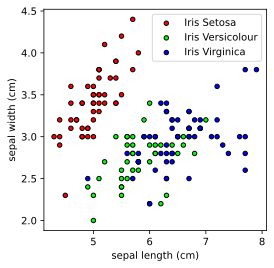

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets
iris = datasets.load_iris()
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000',  '#00FF00', '#0000FF'])

fig, ax = plt.subplots(figsize=(4,4))
for i, iris_class in enumerate(['Iris Setosa', 'Iris Versicolour', 'Iris Virginica']):
    idx = y==i
    ax.scatter(X[idx,0], X[idx,1], 
               c=cmap_bold.colors[i], edgecolor='k', 
               s=20, label=iris_class);
ax.set(xlabel='sepal length (cm)', ylabel='sepal width (cm)')
ax.legend();

The idea behind a KNN classifier is pretty simple: Given a training set $\boldsymbol X \in \mathbb{R}^{N \times D}$ and $\boldsymbol y \in \mathbb{Z}^N$, we predict the label of a new point $\boldsymbol x \in \mathbb{R}^{D}$ __as the label of the majority of its "K nearest neighbor"__ (hence the name KNN) by some distance measure (e.g the Euclidean distance).
Here, $N$ is the number of data points in the dataset, and $D$ is the dimensionality of the data.

### Pairwise distances
We will implement a function `pairwise_distance_matrix` for computing 
the pairwise distances between two datasets $\boldsymbol X$ and $\boldsymbol Y$.
We can then use this pairwise distance matrix to find out the K-nearest neighbors for each row in $\boldsymbol Y$ given $\boldsymbol X$.

You may be tempting to iterate through
rows of $\boldsymbol X$ and $\boldsymbol Y$ and fill in the distance matrix, but that is slow! Can you
think of some way to vectorize your computation (i.e. make it faster by using numpy/scipy operations only)?

In [6]:
# GRADED FUNCTION: DO NOT EDIT THIS LINE

def pairwise_distance_matrix(X, Y):
    """Compute the pairwise distance between rows of X and rows of Y

    Arguments
    ----------
    X: ndarray of size (N, D)
    Y: ndarray of size (M, D)
    
    Returns
    --------
    D: matrix of shape (N, M), each entry D[i,j] is the distance between
    X[i] and Y[j] using the dot product.
    """
    # YOUR CODE HERE
    ### Uncomment and modify the code below
    N, D = X.shape
    M, _ = Y.shape
    distance_matrix = np.zeros((N, M))
    for n in range(N):
        for m in range(M):
            x_min_y = X[n] - Y[m]
            distance_matrix[n][m] = np.sqrt(x_min_y.T @ x_min_y)
    return distance_matrix    

In [7]:
# Test cases for computing pairwise distance matrix.

X_test = np.array([[2., 1],
              [1, 2]])

Y_test = np.array([[0., 1], [1, 1]])

np.testing.assert_allclose(
    pairwise_distance_matrix(X_test, X_test),
    np.array([[0.        , 1.41421356],
              [1.41421356, 0.        ]]))

np.testing.assert_allclose(
    pairwise_distance_matrix(X_test, Y_test),
    np.array([[2.        , 1.        ],
              [1.41421356, 1.        ]])
)

np.testing.assert_allclose(
    pairwise_distance_matrix(Y_test, X_test).T,
    np.array([[2.        , 1.        ],
              [1.41421356, 1.        ]])
)

### Some hidden tests below
### ...

### KNN
Given the `pairwise_distance_matrix` definition above, we are now ready to implement
KNN. We have provided the implementation for you, but do have a look at the code
to get a better understanding of what it does!

In [8]:
# YOUR CODE HERE
def KNN(k, X, y, x):
    """
    K nearest neighbors
    
    k: number of nearest neighbors
    X: training input locations
    y: training labels
    x: test input
    """
    N, D = X.shape
    num_classes = len(np.unique(y))
    dist = pairwise_distance_matrix(X, np.array([x]))
    dist = np.reshape(dist, newshape=(1,-1))[0]

    # Next we make the predictions
    ypred = np.zeros(num_classes)
    classes = y[np.argsort(dist)][:k] # find the labels of the k nearest neighbors
    for c in np.unique(classes):
        ypred[c] += 1
    
    return np.argmax(ypred)

We can also visualize the "decision boundary" of the KNN classifier, which is the region of a problem space in which the output label of a classifier is ambiguous. This would help us develop an intuition of how KNN behaves in practice. The code below plots the decision boundary.

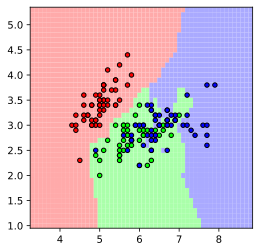

In [9]:
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
step = 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, step),
                     np.arange(y_min, y_max, step))

K = 3
ypred = []
for xtest in np.array([xx.ravel(), yy.ravel()]).T:
    ypred.append(KNN(K, X, y, xtest))

fig, ax = plt.subplots(figsize=(4,4))

ax.pcolormesh(xx, yy, np.array(ypred).reshape(xx.shape), cmap=cmap_light)
ax.scatter(X[:,0], X[:,1], c=y, cmap=cmap_bold, edgecolor='k', s=20);